In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.metrics import cdist_dtw

from tslearn.utils import to_time_series, to_time_series_dataset

In [11]:
# 可視化メソッド
def plot_result(X_train, y_train, name):
    plt.figure(figsize=(12,5))

    # true
    # plt.subplot(1, 2, 1)
    label = np.unique(y_train)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_train == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
        plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{name}')

    plt.tight_layout()
    plt.show()

In [58]:
seed = 0
np.random.seed(seed)

# 75~100%の範囲でランダムに系列長をリサンプリング
range_min = 0.75


# サンプルデータセット（この例ではItalyPowerデータセットを使用）
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("Coffee")

# ランダムに系列長を選択（元の系列長から50%~100%の範囲でランダムに選択）
random_lengths = np.random.randint(range_min * X_train.shape[1], X_train.shape[1], size=X_train.shape[0])

# リサンプリング後のデータセットを格納するためのリスト
resampled_X = []

# 各データごとに系列長をリサンプリング
for i in range(X_train.shape[0]):
    data_point = X_train[i, :, :]
    
    # ランダムに選択された系列長にリサンプリング
    resampled_data_point = TimeSeriesResampler(sz=int(random_lengths[i])).fit_transform(data_point[:,0])

    resampled_X.append(resampled_data_point[0,:,0])

# リサンプリング後のデータセットをnumpy配列に変換
resampled_X = np.array(resampled_X)

# リサンプリング後のデータセットをTimeSeriesクラスに変換
# resampled_X = [to_time_series(data) for data in resampled_X]
resampled_X = to_time_series_dataset(resampled_X) # 不均一な系列長をNaNで埋める処理

/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_41600/2824803275.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resampled_X = np.array(resampled_X)


In [59]:
type(resampled_X)

numpy.ndarray

In [60]:
resampled_X[0].shape

(284, 1)

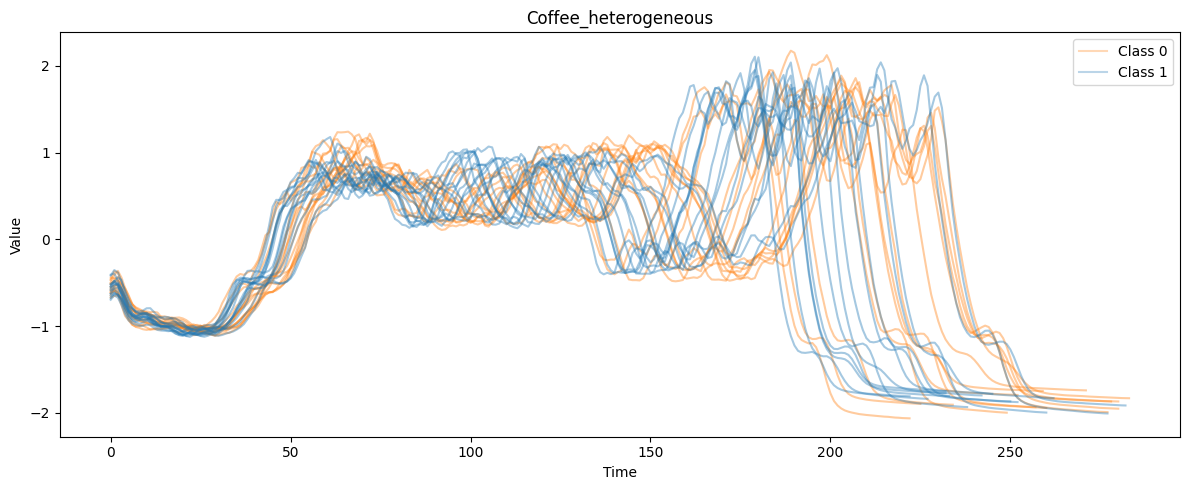

In [61]:
plot_result(resampled_X, y_train, 'Coffee_heterogeneous')

k-meansを適用

In [64]:
# 可視化メソッド
def plot_clustering(X_train, y_train, best_ind, km_li, name):
    plt.figure(figsize=(12,5))

    # true
    plt.subplot(1, 2, 1)
    label = np.unique(y_train)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_train == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
        plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{name} True')

    # pred
    plt.subplot(1,2,2)
    best_k = best_ind + 1
    best_km = km_li[best_ind]
    y_pred = best_km.predict(X_train) + 1

    label = np.unique(y_pred)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_pred == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.1)
        plt.plot(best_km.cluster_centers_[class_label - 1], label=f'Class {class_label}',
                color=colors[class_label - 1], linewidth=3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.title(f'{name} Pred')
    plt.tight_layout()
    plt.show()

DBA k-means 1
	dist:  0.5828072870083579
DBA k-means 2
	dist:  0.41854579386631524
DBA k-means 3
	dist:  0.32700833215353936
DBA k-means 4
	dist:  0.2945136067497744
DBA k-means 5
	dist:  0.27490789527856585


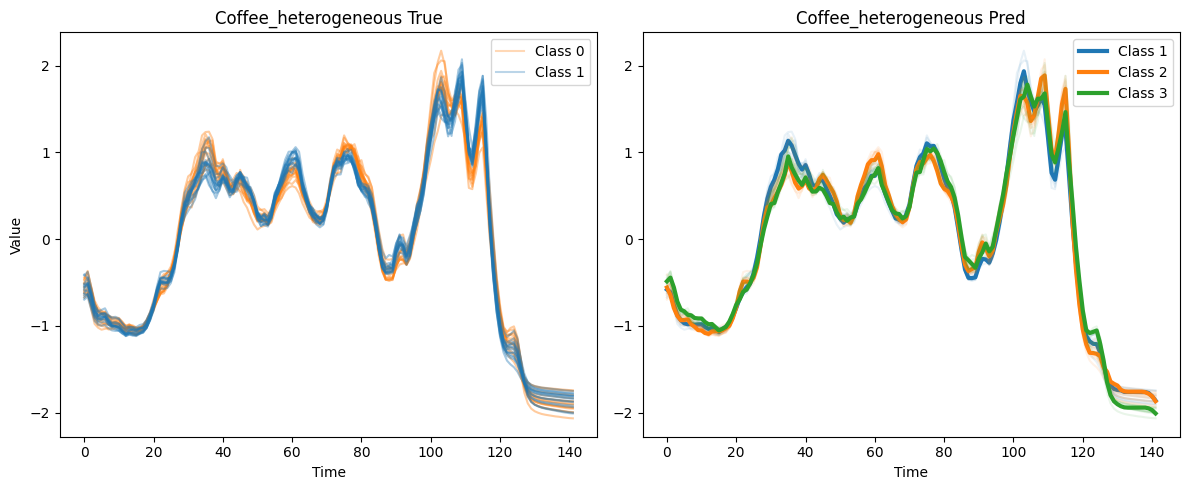

In [70]:
seed = 0
np.random.seed(seed)
name = 'Coffee_heterogeneous'

X_train = resampled_X

# Make time series shorter
X_train = TimeSeriesResampler(sz=int(X_train.shape[1]/2)).fit_transform(X_train)
sz = X_train.shape[1]

# DBA-k-means
dist_li = []
km_li = []
for i in range(5):
    k_cluster = i+1

    print(f'DBA k-means {k_cluster}')
    dba_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                n_init=2,
                                metric="dtw",
                                verbose=False,
                                max_iter_barycenter=10,
                                random_state=seed)
    y_pred = dba_km.fit_predict(X_train)
    km_li.append(dba_km)
    dist_li.append(dba_km.inertia_)

    print('\tdist: ', dist_li[i])

dist_rate = [dist_li[i]/dist_li[i-1] for i in range(len(dist_li)) if i!=0]
best_ind = np.max([i for i, num in enumerate(dist_rate) if num < 0.8]) + 1

plot_clustering(X_train, y_train, best_ind, km_li, name)

In [67]:
resampled_X[0].shape

(284, 1)

オリジナルのデータセットにもクラスタリングを適用

DBA k-means 1
	dist:  0.6132909583451706
DBA k-means 2
	dist:  0.4254360937163429
DBA k-means 3
	dist:  0.3642554901766152
DBA k-means 4
	dist:  0.33000387200830633
DBA k-means 5
	dist:  0.30169493644241335


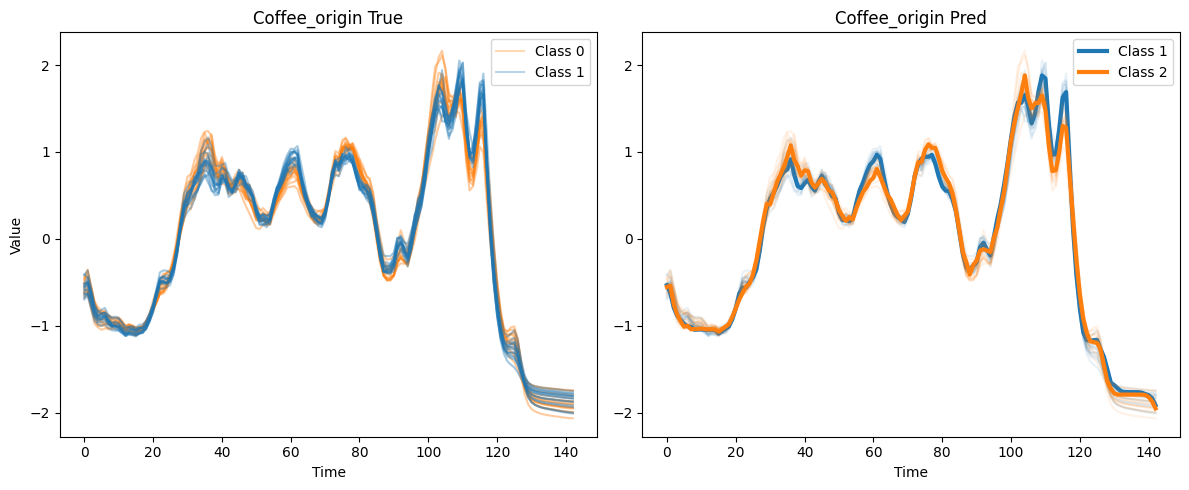

In [72]:
seed = 0
np.random.seed(seed)
name = 'Coffee_origin'

# サンプルデータセット（この例ではItalyPowerデータセットを使用）
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("Coffee")

# Make time series shorter
X_train = TimeSeriesResampler(sz=int(X_train.shape[1]/2)).fit_transform(X_train)
sz = X_train.shape[1]

# DBA-k-means
dist_li = []
km_li = []
for i in range(5):
    k_cluster = i+1

    print(f'DBA k-means {k_cluster}')
    dba_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                n_init=2,
                                metric="dtw",
                                verbose=False,
                                max_iter_barycenter=10,
                                random_state=seed)
    y_pred = dba_km.fit_predict(X_train)
    km_li.append(dba_km)
    dist_li.append(dba_km.inertia_)

    print('\tdist: ', dist_li[i])

dist_rate = [dist_li[i]/dist_li[i-1] for i in range(len(dist_li)) if i!=0]
best_ind = np.max([i for i, num in enumerate(dist_rate) if num < 0.8]) + 1

plot_clustering(X_train, y_train, best_ind, km_li, name)

系列長を不均一にリサンプリングしたものと、オリジナルデータセットとではクラスタリング結果が異なる。当然っちゃ当然の結果。

### TimeSeriesScalerMinMaxを試す

In [88]:
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

In [81]:
resampled_X_ = TimeSeriesScalerMinMax().fit_transform(resampled_X)

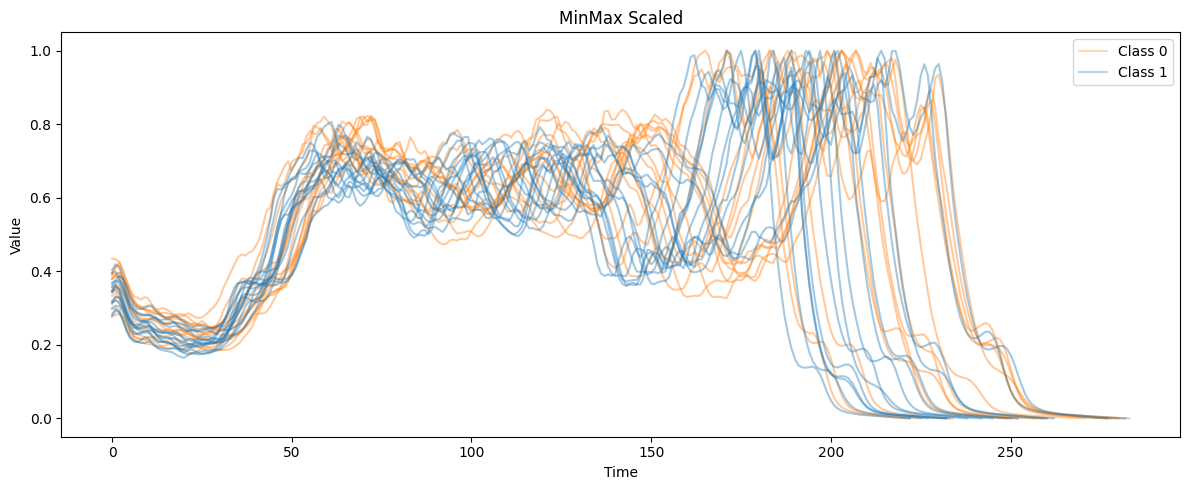

In [86]:
plot_result(resampled_X_, y_train, 'MinMax Scaled')

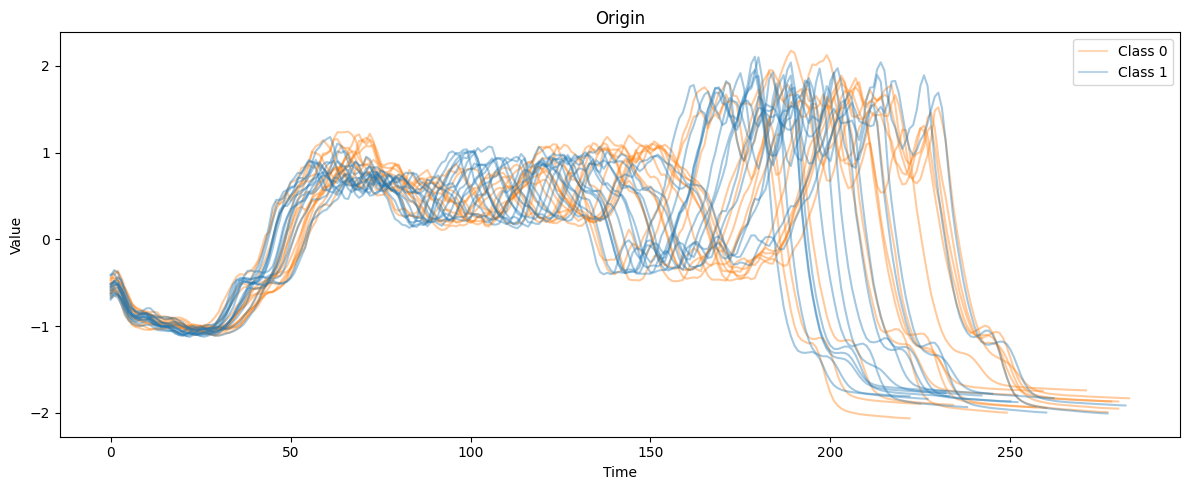

In [87]:
plot_result(resampled_X, y_train, 'Origin')

TimeSeriesScalerMinMaxはデータ点内でのminmaxをスケールしているように思われる。
ちなみにデフォルトでは(0,1)でスケールされる

In [89]:
resampled_X_ = TimeSeriesScalerMeanVariance().fit_transform(resampled_X)

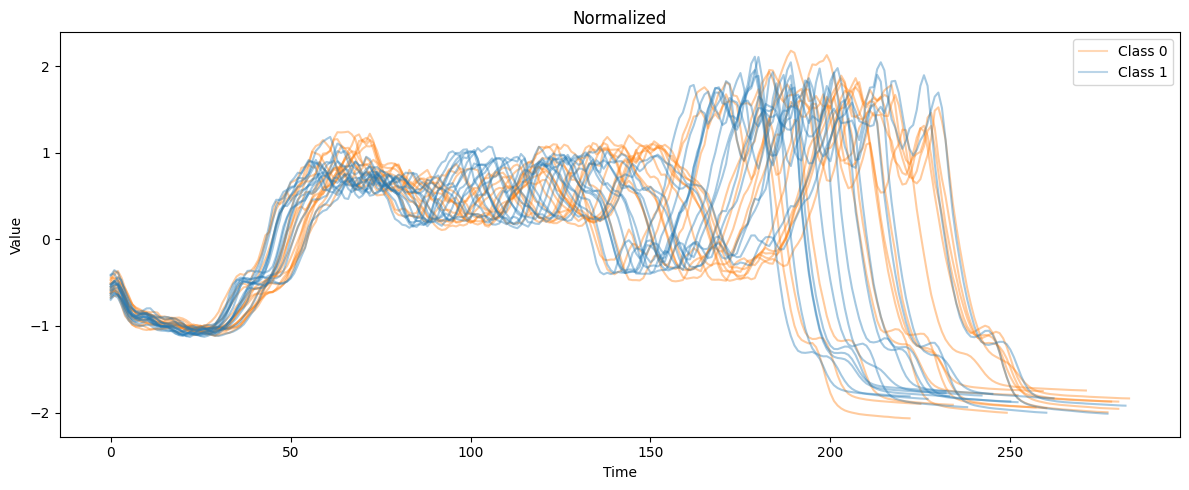

In [90]:
plot_result(resampled_X_, y_train, 'Normalized')

標準化もデータ点内でのスケールである

データ点内でのスケールであれば、系列長が不均一であっても適用可能と判断できる